In [3]:
cd /content/drive/My Drive/data-collection-from-transportation-platforms-morocco

/content/drive/My Drive/data-collection-from-transportation-platforms-morocco


In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from keras import backend as K
from keras import regularizers
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, SpatialDropout1D, Activation, concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers.advanced_activations import ReLU, PReLU, LeakyReLU, ELU
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model,Sequential
from keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.models import model_from_json
import requests,json

In [0]:
LABEL_COLUMN = "rating"

CATEGORICAL_COLUMNS = [
    'from', 'to' ,'session','gender', 'profission','dayofweek','company','route'
]

CONTINUOUS_COLUMNS = [
    'distance','duration', 'price','age'
]

In [0]:
def swish(x):
    return (K.sigmoid(x) * x)

In [0]:
def preprocessing():
    data = pd.read_csv('dataset.csv',delimiter =';')
    # print(data.shape)
    # Convert the position of each starting city to a number 
    a = data.groupby(['from_lat','from_lan']).size()
    from_dict = {}
    for i,row in enumerate(a.iteritems()):
        from_dict[row[0]] = i
    f = data[['from_lat','from_lan']]
    from_col = []
    for a,b in f.iterrows():
        from_col.append(from_dict[(b['from_lat'],b['from_lan'])])
    data['from'] = from_col
    #data = data.drop(['from_lat','from_lan'],axis = 1)
    # Convert the position of each arrival city to a number 
    a = data.groupby(['to_lat','to_lan']).size()
    to_dict = {}
    for i,row in enumerate(a.iteritems()):
        to_dict[row[0]] = i
    f = data[['to_lat','to_lan']]
    to_col = []
    for a,b in f.iterrows():
        to_col.append(to_dict[(b['to_lat'],b['to_lan'])])
    data['to'] = to_col
    #data = data.drop(['to_lat','to_lan'],axis = 1)

    ######## keep a portion of data to test ###########

    test_final = data.sample(frac=0.001,random_state=200)
    data = data.drop(test_final.index)

    ####################################################

    encoders = {}
    for c in CATEGORICAL_COLUMNS:
        le = LabelEncoder()
        data[c] = le.fit_transform(data[c])
        encoders[c] = le

    # train,validation,test split
    
    train= data.sample(frac=0.8,random_state=200)
    val = data.drop(train.index).sample(frac = 0.5,random_state=200)
    test= data.drop(train.index).drop(val.index)
    
    y_train = train['rating'].values
    y_val = val['rating'].values
    y_test = test['rating'].values
    
    x_train_categ = np.array(train[CATEGORICAL_COLUMNS]) 
    x_val_categ = np.array(val[CATEGORICAL_COLUMNS])
    x_test_categ = np.array(test[CATEGORICAL_COLUMNS])

    x_train_conti = np.array(train[CONTINUOUS_COLUMNS], dtype='float64') 
    x_val_conti = np.array(val[CONTINUOUS_COLUMNS], dtype='float64')
    x_test_conti = np.array(test[CONTINUOUS_COLUMNS], dtype='float64')

    x_train = train.drop(['rating', 'accident', 'retard', 'trafic','from','to','security',],axis=1)
    x_val = val.drop(['rating', 'accident',  'retard', 'trafic','from','to','security',],axis=1)
    x_test = test.drop(['rating', 'accident',  'retard', 'trafic','from','to','security',],axis=1)

    scaler = StandardScaler()
    x_train_conti = scaler.fit_transform(x_train_conti)
    x_val_conti = scaler.transform(x_val_conti)    
    x_test_conti = scaler.transform(x_test_conti)
    return [x_train, y_train, x_val, y_val, x_test, y_test, x_train_categ, x_val_categ, x_test_categ, x_train_conti,x_val_conti, x_test_conti, data,from_dict,to_dict,encoders,scaler,test_final]

In [0]:
x_train, y_train, x_val, y_val, x_test, y_test, x_train_categ, x_val_categ, x_test_categ, x_train_conti,x_val_conti, x_test_conti, data,from_dict,to_dict,encoders,scaler,test_final = preprocessing()

In [0]:
np.save('from_dict.npy',from_dict)
np.save('to_dict.npy',to_dict)
np.save('encoders.npy',encoders)
np.save('scaler.npy',scaler)
np.save('test_final.npy',test_final)

In [0]:
# i will try to mix an ordinary ANN with a Deep Embedding NN 
class FF_and_Deep:
    def __init__(self,x_train, y_train, x_val, y_val, x_test, y_test, x_train_categ,x_val_categ, x_test_categ, x_train_conti,x_val_conti, x_test_conti, data):
        self.x_train = x_train
        self.y_train = to_categorical(y_train)
        self.x_val = x_val
        self.y_val = to_categorical(y_val)
        self.x_test = x_test
        self.y_test = to_categorical(y_test)
        self.x_train_categ = x_train_categ 
        self.x_val_categ = x_val_categ 
        self.x_test_categ = x_test_categ 
        self.x_train_conti = x_train_conti 
        self.x_test_conti = x_test_conti 
        self.x_val_conti = x_val_conti 
        self.all_data = data
        self.categ_inputs = None
        self.conti_input = None
        self.deep_component_outlayer = None
        self.ff_component_outlayer = None
        self.ff_input = None
        self.model = None
    
    def deep_component(self,layers,embed_size,batch_norm,dropout):
        categ_inputs = []
        categ_embeds = []
        # Create Input layer and Embedding layer for each feature of category data
        for i in range(len(CATEGORICAL_COLUMNS)):
            input_i = Input(shape=(1,), dtype='int32')
            dim = len(np.unique(self.all_data[CATEGORICAL_COLUMNS[i]]))
            embed_dim = embed_size #int(np.ceil(dim ** 0.25)) # TO TUNE
            embed_i = Embedding(dim, embed_dim, input_length=1,trainable = True)(input_i)
            flatten_i = Flatten()(embed_i)
            categ_inputs.append(input_i)
            categ_embeds.append(flatten_i)
        # Continuous data is input collectively in all connected layers
        conti_input = Input(shape=(len(CONTINUOUS_COLUMNS),))
        conti_dense = Dense(embed_size)(conti_input)
        # Attach the output of all connected layers and each Embedding
        concat_embeds = concatenate([conti_dense]+categ_embeds)
        out = ReLU()(concat_embeds)
        if batch_norm :
          out = BatchNormalization()(out)
        # Furthermore, three layers of all bonding layers are stacked
        for layer in layers:
          out = Dense(layer,kernel_regularizer=regularizers.l2(0.01))(out)
          out = ReLU()(out)
          if dropout != 0:
            out = Dropout(dropout)(out)
          if batch_norm:
            out = BatchNormalization()(out)
        # Convert input and last layers into member variables (for model creation)
        self.categ_inputs = categ_inputs
        self.conti_input = conti_input
        self.deep_component_outlayer = out
    
    def ff_component(self,layers,dropout,batch_norm):
        # Include only category data in linear model
        dim = self.x_train.shape[1]
        self.ff_input = Input(shape=(dim,))
        out = self.ff_input
        for layer in layers:
          out = Dense(layer,kernel_regularizer=regularizers.l2(0.01))(out)
          out = ReLU()(out)
          if dropout != 0:
            out = Dropout(dropout)(out)
          if batch_norm:
            out = BatchNormalization()(out)
        self.ff_component_outlayer = out

    def create_model(self,layers,embedding_size=16,batch_norm=True,dropout=0):
        # create the separate components 
        self.deep_component(layers[0],embedding_size,batch_norm,dropout)
        self.ff_component(layers[1],dropout,batch_norm)
        out = concatenate([self.deep_component_outlayer, self.ff_component_outlayer])
        inputs = [self.conti_input] + self.categ_inputs + [self.ff_input]
        for layer in layers[2]:
          out = Dense(layer,kernel_regularizer=regularizers.l2(0.01))(out)
          out = ReLU()(out)
          if dropout != 0:
            out = Dropout(dropout)(out)
          if batch_norm:
            out = BatchNormalization()(out)
        output = Dense(self.y_train.shape[1], activation='softmax')(out)
        self.model = Model(inputs=inputs, outputs=output)
        
    def train_model(self, epochs=15, optimizer='adam', batch_size=64):
        train_data = [self.x_train_conti] +\
                      [self.x_train_categ[:, i] for i in range(self.x_train_categ.shape[1])] +\
                      [self.x_train]
        val_data =   [self.x_val_conti] +\
                      [self.x_val_categ[:, i] for i in range(self.x_train_categ.shape[1])] +\
                      [self.x_val]

        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        self.model.fit(train_data, self.y_train,validation_data=(val_data,self.y_val) ,epochs=epochs, batch_size=batch_size)

    def evaluate_model(self):
      input_data = [self.x_test_conti] +\
                    [self.x_test_categ[:, i] for i in range(self.x_test_categ.shape[1])] +\
                    [self.x_test]
      loss, acc = self.model.evaluate(input_data, self.y_test)
      print(f'test_loss: {loss} - test_acc: {acc}')

    def save_model(self, filename='ff_and_deep.h5',jsonfilename='ff_and_deep.json'):
      classifier_json = self.model.to_json()
      with open(jsonfilename, "w") as json_file:
          json_file.write(classifier_json)
      # serialize weights to HDF5
      self.model.save_weights(filename)
      print("Saved classifier to disk")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


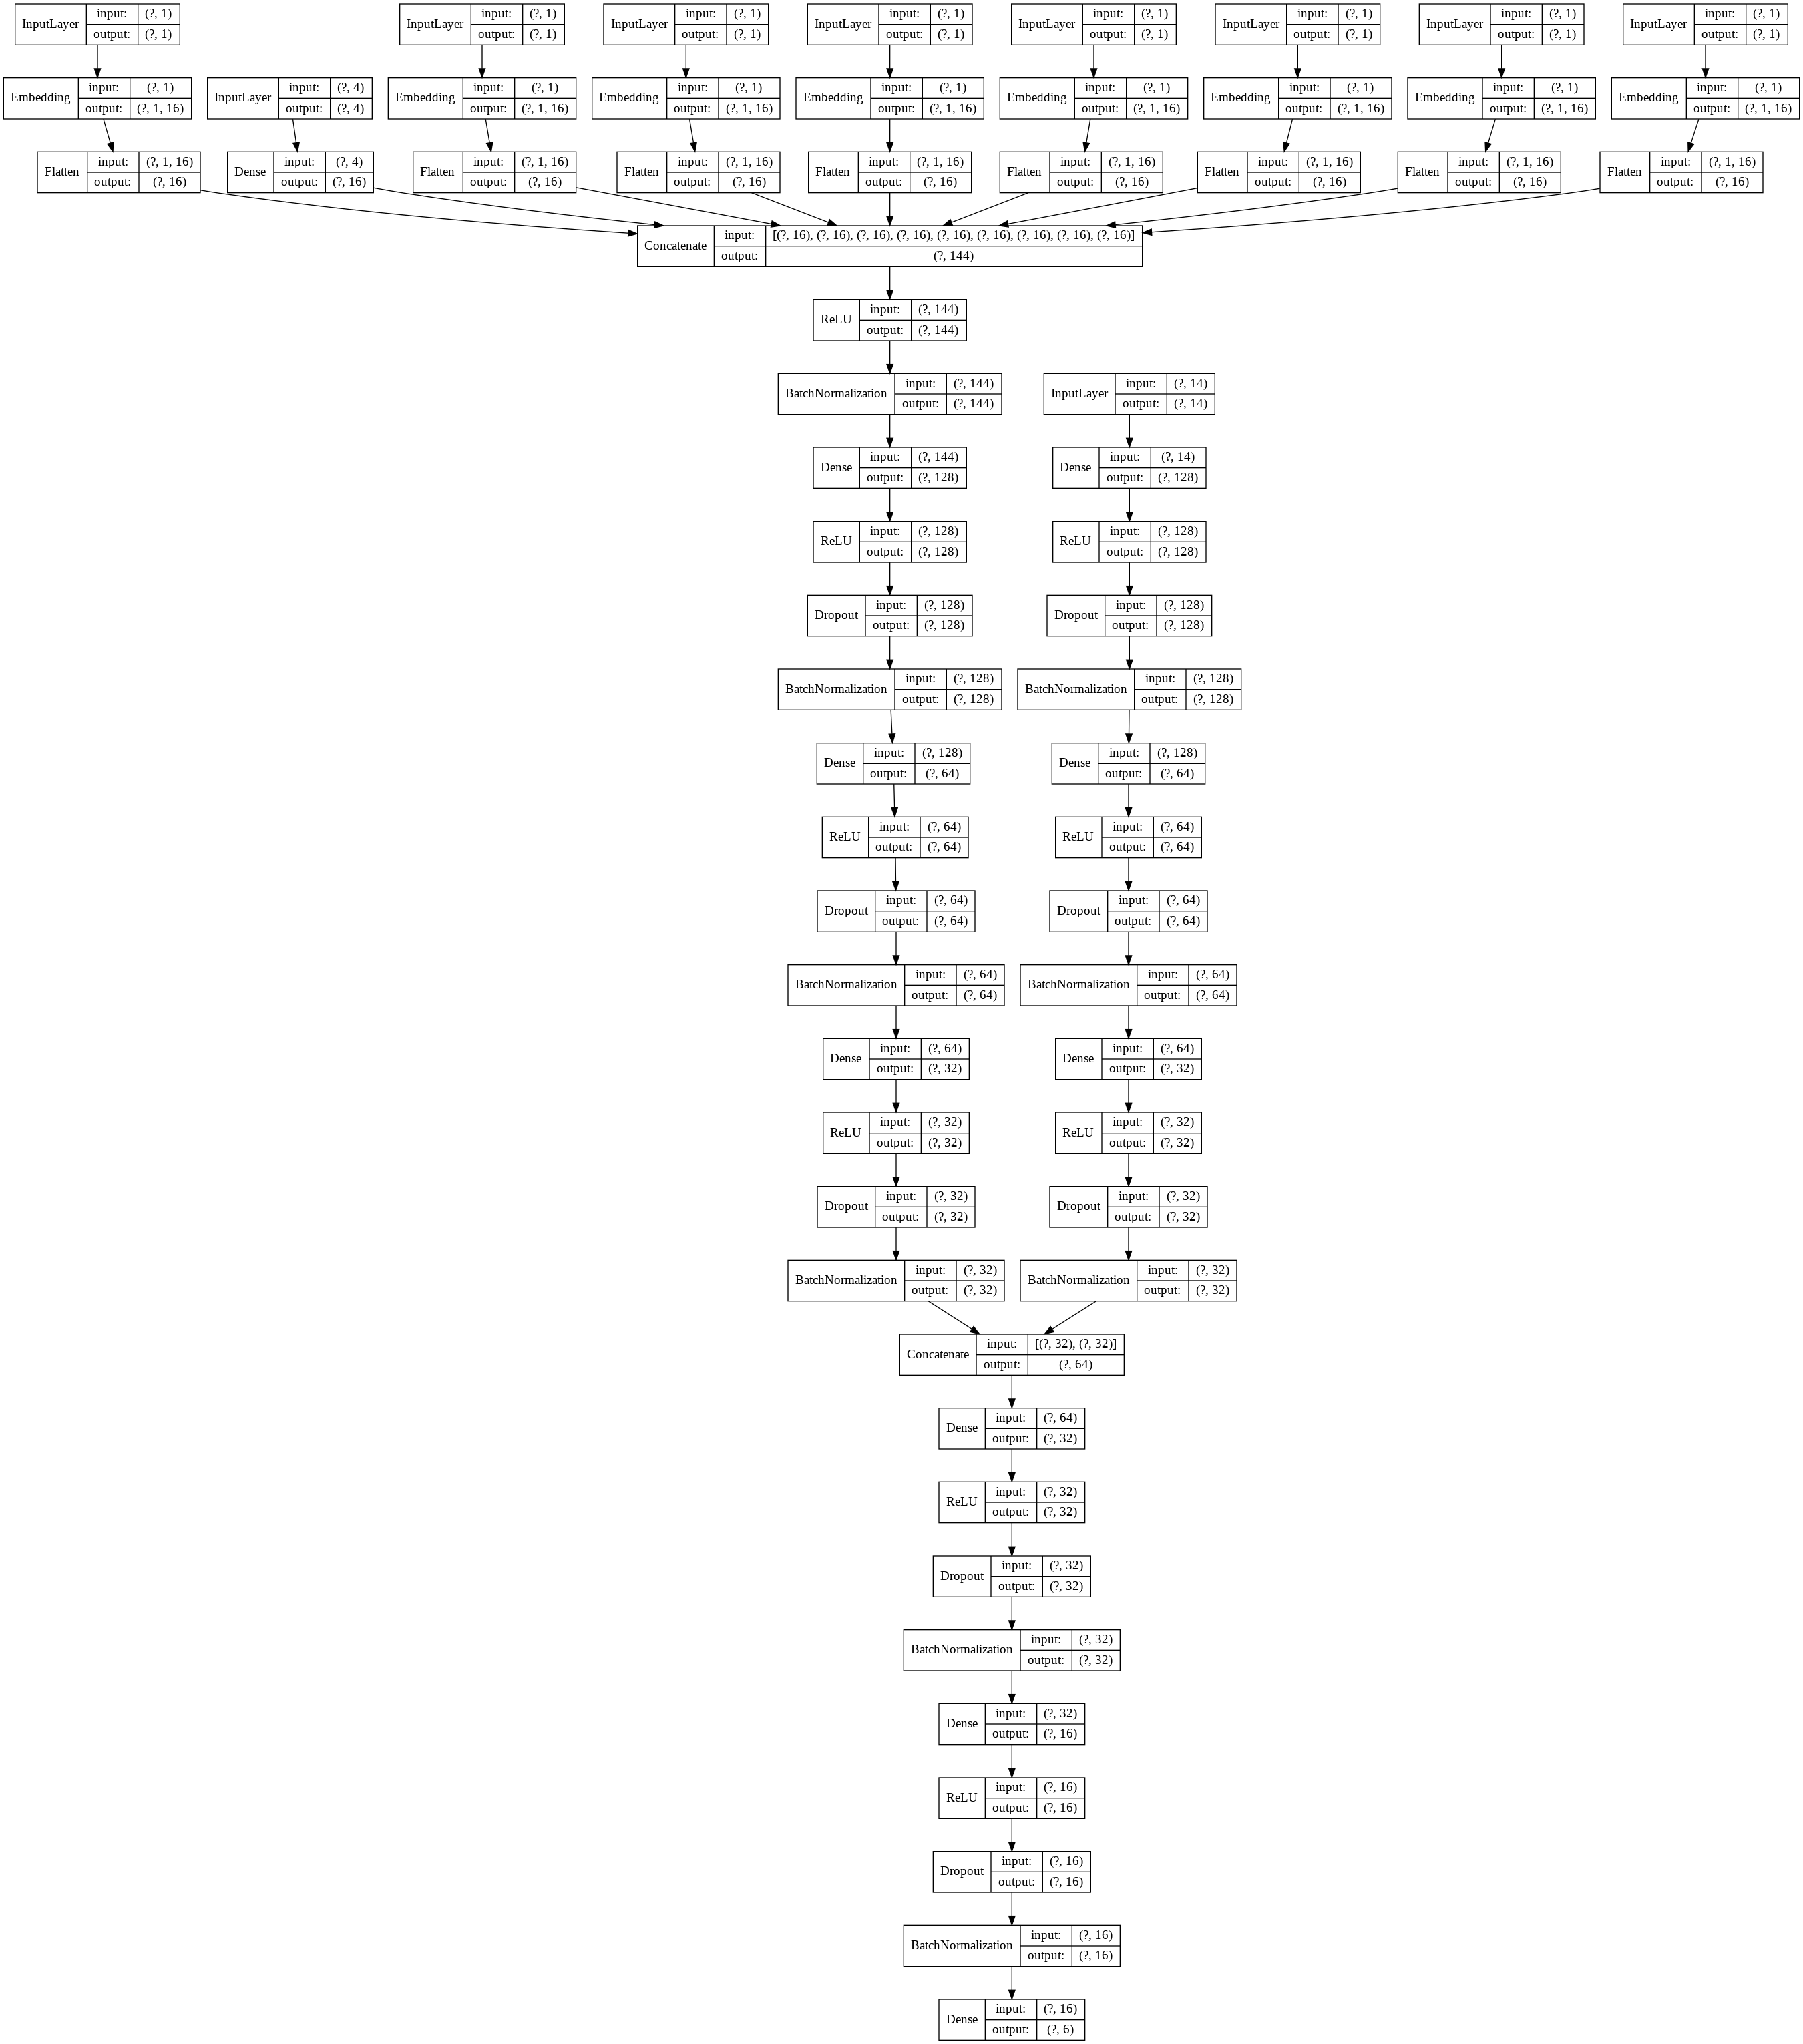

In [0]:
ff_deep_net = FF_and_Deep(x_train, y_train, x_val, y_val, x_test, y_test, x_train_categ,x_val_categ, x_test_categ, x_train_conti,x_val_conti, x_test_conti, data)
ff_deep_net.create_model(layers=[[128,64,32],[128,64,32],[32,16]],batch_norm=True,dropout=0.2)
plot_model(ff_deep_net.model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [0]:
ff_deep_net.train_model()


Train on 904374 samples, validate on 113047 samples
Epoch 1/15
904374/904374 [==============================] - 88s 97us/step - loss: 0.3854 - accuracy: 0.9373 - val_loss: 0.1940 - val_accuracy: 0.9583
Epoch 2/15
904374/904374 [==============================] - 84s 92us/step - loss: 0.2385 - accuracy: 0.9498 - val_loss: 0.1854 - val_accuracy: 0.9592
Epoch 3/15
904374/904374 [==============================] - 84s 93us/step - loss: 0.2304 - accuracy: 0.9500 - val_loss: 0.1843 - val_accuracy: 0.9583
Epoch 4/15
904374/904374 [==============================] - 84s 93us/step - loss: 0.2228 - accuracy: 0.9507 - val_loss: 0.1818 - val_accuracy: 0.9579
Epoch 5/15
904374/904374 [==============================] - 84s 93us/step - loss: 0.2234 - accuracy: 0.9501 - val_loss: 0.1783 - val_accuracy: 0.9590
Epoch 6/15
904374/904374 [==============================] - 84s 93us/step - loss: 0.2248 - accuracy: 0.9496 - val_loss: 0.1874 - val_accuracy: 0.9589
Epoch 7/15
904374/904374 [=====================

In [0]:
ff_deep_net.evaluate_model()

113047/113047 [==============================] - 5s 43us/step
test_loss: 0.1818255978124042 - test_acc: 0.9589285850524902


In [0]:
ff_deep_net.save_model()

Saved classifier to disk


In [0]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [0]:
def modelTesting():
  ALL_COLUMNS = ['company', 'from_lat', 'from_lan', 'to_lat', 'to_lan', 'distance',
       'duration', 'dayofweek', 'price', 'session', 'age', 'gender',
       'profission', 'accident', 'retard', 'security', 'trafic', 'route',
       'rating']

  LABEL_COLUMN = "rating"

  CATEGORICAL_COLUMNS = [
    'from', 'to' ,'session','gender', 'profission','dayofweek','company','route'
  ]

  CONTINUOUS_COLUMNS = [
    'distance','duration', 'price','age'
  ]

  # load all serialized encoders and scallers and test data 
  from_dict = np.load('from_dict.npy',allow_pickle=True).item()
  to_dict = np.load('to_dict.npy',allow_pickle=True).item()
  encoders = np.load('encoders.npy',allow_pickle=True).item()
  scaler = np.load('scaler.npy',allow_pickle=True).item()
  test_final = np.load('test_final.npy',allow_pickle=True)

  # preprocess
  data = pd.DataFrame(test_final,columns=ALL_COLUMNS + ['from','to'])
  for c in CATEGORICAL_COLUMNS:
    data[c] = encoders[c].transform(data[c])
  
  # split our data into 3 groups categorical , continuous and all data
  y_test = np.array(data['rating'], dtype='int64')
  print(y_test.min(),y_test.max())
  x_test_categ = np.array(data[CATEGORICAL_COLUMNS])
  x_test_conti = np.array(data[CONTINUOUS_COLUMNS], dtype='float64')
  x_test_conti = scaler.transform(x_test_conti)
  x_test = data.drop(['rating', 'accident', 'retard', 'trafic','from','to','security',],axis=1)
  # Load our model
  json_file = open('ff_and_deep.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights("ff_and_deep.h5")

  x_test = [x_test_conti] + [x_test_categ[:, i] for i in range(x_test_categ.shape[1])] +[x_test]
  y_pred = loaded_model.predict(x_test)
  y_pred = np.argmax(y_pred,axis=1)
  print(y_pred.min(),y_pred.max())
  cm = confusion_matrix(y_test, y_pred)
  plot_confusion_matrix(cm,range(y_test.min(),y_test.max()+1),normalize=True)

2 5
2 5


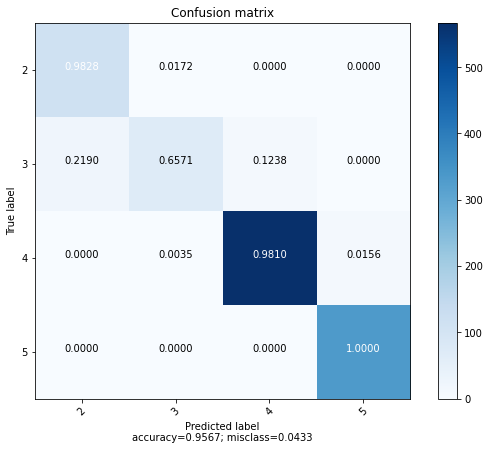

In [0]:
modelTesting()

In [0]:
def getLocationOfCity(city):
    api_key = '966a766bb88e4cb5a5f78ffd9ec99208'
    req = requests.get('https://api.opencagedata.com/geocode/v1/json?q='+city+'&key='+api_key)
    js = json.loads(req.text)
    rep = None
    for res in js['results']:
        if res['formatted'].split(',')[-1] == " Morocco":
            rep = res['geometry'] 
            break
    return rep

In [0]:
oncfDF = pd.read_csv("Bots/oncfTrips.csv",delimiter=";",encoding='utf-8')
ctmDF = pd.read_csv("Bots/CTMTrips.csv",delimiter=";",encoding='latin-1')
covDF = pd.read_csv("Bots/cov.csv",delimiter=",",encoding='latin-1')

In [0]:
cities = list(oncfDF['from'])
cities.extend(list(oncfDF['to']))
cities.extend(list(ctmDF['from']))
cities.extend(list(ctmDF['to']))

In [0]:
cities = list(set(cities))
cities = [city.upper() for city in cities]
cities = list(set(cities))

In [45]:
locations

{'AEROPORT MED V': {'lat': 33.3699749, 'lng': -7.5879118},
 'AGADIR': {'lat': 30.4211144, 'lng': -9.5830626},
 'AGADIR  (SUPRAT.)': {'lat': 30.42018, 'lng': -9.59815},
 'AIN SEBAA': {'lat': 34.2296268, 'lng': -6.528318},
 'AIN-TAOUJDATE': {'lat': 33.940302, 'lng': -5.208052},
 'AL HOCEIMA': {'lat': 35.245114, 'lng': -3.930186},
 'ASILAH': {'lat': 35.461928, 'lng': -6.036545},
 'AZROU': {'lat': 33.436117, 'lng': -5.221913},
 'BENGUERIR': {'lat': 32.235967, 'lng': -7.946685},
 'BENI MELLAL': {'lat': 32.334193, 'lng': -6.353335},
 'BENI-MELLAL': {'lat': 32.334193, 'lng': -6.353335},
 'BERKANE': {'lat': 34.9266755, 'lng': -2.3294087},
 'BERRECHID': {'lat': 33.2676746, 'lng': -7.5811465},
 'BOUZNIKA': {'lat': 33.781005, 'lng': -7.1610294},
 'CASA PORT': {'lat': 33.5993825, 'lng': -7.6123131},
 'CASA VOYAGEURS': {'lat': 33.5903553, 'lng': -7.5896849},
 'CASABLANCA AIN SEBAA': {'lat': 33.6085906, 'lng': -7.5241441},
 'CASABLANCA FAR': {'lat': 33.7048912, 'lng': -7.3931015},
 'CASABLANCA MAARI

In [0]:
locations['SIDI SLIMANE MEDINA']={'lat': 34.2737827,'lng':-5.9806831}
locations['KELAA  DES  SRAGHNAS']={'lat' :32.0510291,'lng':-7.4206207}
locations['GUELMIMA']={'lat' :31.6844986,'lng':-4.979725}
locations['AEROPORT MED V']={'lat' :33.3699749,'lng':-7.5879118}

In [0]:
np.save('locations.npy',locations)

In [0]:
def test(from_city,to_city):
  ALL_COLUMNS = ['company', 'from_lat', 'from_lan', 'to_lat', 'to_lan', 'distance',
       'duration', 'dayofweek', 'price', 'session', 'age', 'gender',
       'profission', 'accident', 'retard', 'security', 'trafic', 'route',
       'rating']

  LABEL_COLUMN = "rating"

  CATEGORICAL_COLUMNS = [
    'from', 'to' ,'session','gender', 'profission','dayofweek','company','route'
  ]

  CONTINUOUS_COLUMNS = [
    'distance','duration', 'price','age'
  ]

  from_dict = np.load('from_dict.npy',allow_pickle=True).item()
  to_dict = np.load('to_dict.npy',allow_pickle=True).item()
  encoders = np.load('encoders.npy',allow_pickle=True).item()
  scaler = np.load('scaler.npy',allow_pickle=True).item()
  locations = np.load('locations.npy',allow_pickle=True).item()

  #read the database this part will be removed if we have a clean dataset 
  data = pd.read_csv('dataset.csv',delimiter =';')
  print(locations[from_city]['lat'])

  # select all trips that have from and to cities in the request
  request = data[np.isclose(data['from_lat'],locations[from_city]['lat']) & np.isclose(data['from_lan'],locations[from_city]['lng']) & np.isclose(data['to_lat'],locations[to_city]['lat']) & np.isclose(data['to_lan'],locations[to_city]['lng'])]
  f = request[['from_lat','from_lan']]
  from_col = []
  for a,b in f.iterrows():
      from_col.append(from_dict[(b['from_lat'],b['from_lan'])])
  request['from'] = from_col
  t = request[['to_lat','to_lan']]
  to_col = []
  for a,b in t.iterrows():
      to_col.append(to_dict[(b['to_lat'],b['to_lan'])])
  request['to'] = to_col
  # preprocess
  for c in CATEGORICAL_COLUMNS:
    request[c] = encoders[c].transform(request[c])
  # split our data into 3 groups categorical , continuous and all data
  y_test = np.array(request['rating'], dtype='int64')
  print(y_test.min(),y_test.max())
  x_test_categ = np.array(request[CATEGORICAL_COLUMNS])
  x_test_conti = np.array(request[CONTINUOUS_COLUMNS], dtype='float64')
  x_test_conti = scaler.transform(x_test_conti)
  x_test = request.drop(['rating', 'accident', 'retard', 'trafic','from','to','security',],axis=1)
  # Load our model
  json_file = open('ff_and_deep.json', 'r')
  loaded_model_json = json_file.read()
  json_file.close()
  loaded_model = model_from_json(loaded_model_json)
  # load weights into new model
  loaded_model.load_weights("ff_and_deep.h5")

  x_test = [x_test_conti] + [x_test_categ[:, i] for i in range(x_test_categ.shape[1])] +[x_test]
  y_pred = loaded_model.predict(x_test)
  y_pred = np.argmax(y_pred,axis=1)
  print(y_pred.min(),y_pred.max())
  cm = confusion_matrix(y_test, y_pred)
  plot_confusion_matrix(cm,range(y_test.min(),y_test.max()+1),normalize=True)

34.0346534


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

2 5
2 5


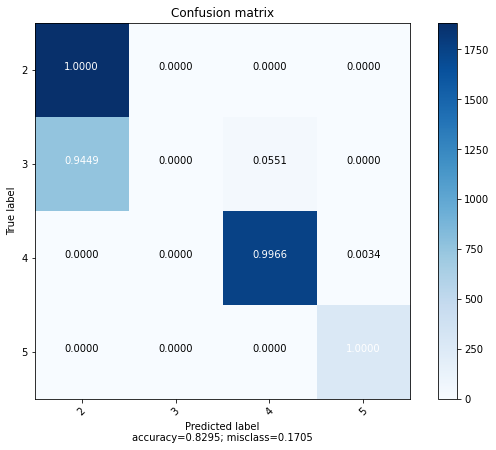

In [74]:
test('FES','RABAT')